# 1. 权重衰退 Weight Decay
- 因为W可以选择得范围越大，模型越复杂,为了避免W变得特别大
<img src="./pic/权重衰退.PNG" width=300 height=300>

## 使用均方范数作为硬性限制
- 更强的正则项，意味着对w的限制比较强，当theta=0，限制最高
<img src="./pic/使用均方范数作为硬性限制.PNG" width=300 height=300>

## 使用均方范数作为柔性限制
- lambda = 0，等价于theta无穷大
- lambda = 无穷大，等价于theta = 0
- 控制模型，不想让模型变得复杂，可以通过控制lambda，满足需求
- ||w||<sup>2</sup>，向量w的L2范数的平方
<img src="./pic/使用均方范数作为柔性限制.PNG" width=300 height=300>

## 罚（正则项）的加入，对最优解的影响
- 绿线为L2 loss等高线，w~<sup>*</sup>为l2 loss的最优解
    - 根据L2 loss的梯度下降：离最优点越远，梯度下降的速度越快
- 橙线为罚（以原点为圆心，半径为w的圆），w<sup>*</sup>为多项式（加入罚）的最优解
- L2 loss与罚，相互拉扯最优点
- 罚的引入（正则项）就是防止达到损失函数最优导致过拟合，把损失函数最优点往外拉一拉
<img src="./pic/罚对最优解的影响.PNG" width=300 height=300>

## 参数更新法则
- 与原损失函数求导（梯度下降）公式差不多（都是减去梯度的负方向乘以学习率）
- 唯一区别：w<sub>t</sub>每次都乘以小于1的常数。也就是**权重衰退**
<img src="./pic/参数更新法则.PNG" width=300 height=300>

## 总结
- 权重衰退通过L2正则项，使得模型参数不会过大，从而控制模型复杂度
- 正则项权重lambda是控制模型复杂度的超参数

# 2. 权重衰减代码实现
- 权重衰减是最广泛使用的正则化的技术之一
- 生成一些数据
<img src="./pic/生成数据的公式.PNG" width=300 height=300>
- 偏置：0.05
- x<sub>i</sub>：随机输入
- 噪音epsilon：均值为0，方差为0.01的正态分布

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 故意选取小数据，为了使模型过拟合（数据越简单，模型越复杂，越容易过拟合）
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 【核心】定义L2范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2  # w ** 2

### 【补充】定义L1范数惩罚

In [5]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))  # \w\

## 定义训练代码

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)    # 唯一的区别
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

## 忽略正则化直接训练

w的L2范数是： 12.39106273651123


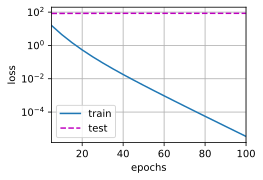

In [7]:
train(lambd=0)
# 下图明显过拟合，训练集loss下降，但验证集loss不变

## 使用权重衰减

w的L2范数是： 0.3344910442829132


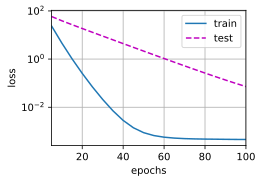

In [8]:
train(lambd=3)

w的L2范数是： 0.02248833142220974


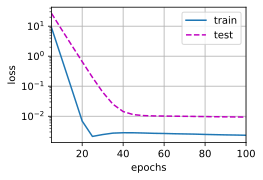

In [9]:
train(lambd=10)

w的L2范数是： 12.695831298828125


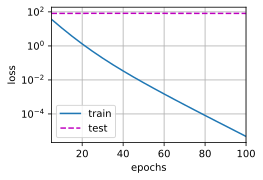

In [10]:
train(lambd=0.01)

# 3. 简洁实现

In [11]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,
         'weight_decay': wd},    # 设置权重衰减
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.645380020141602


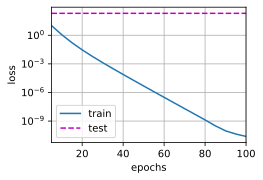

In [12]:
train_concise(0)

w的L2范数： 0.5744501948356628


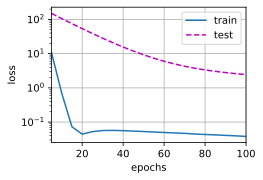

In [13]:
train_concise(3)